In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import random
import pydot
import graphviz
from IPython.display import display
#warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


In [2]:
import warnings
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, RepeatVector, SpatialDropout1D, SimpleRNN, GRU, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')

In [3]:
def concatenate_signals(window , mean1, mean2, overlap ):
    """
    Функция принимает размер будущего сигнала, параметры усреднения стыка сигналов, перекрытие, и частоту дискретизации
    :param window:
    :param mean1:
    :param mean2:
    :param overlap:
    :param SAMPLE_RATE:
    :return: signal + label
    """
    duration = window * 2  # Секунды
    if overlap == 0:
        x1 = np.random.normal(0,1,duration)
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna()
        x1 = x1/(np.abs(x1).max())
        return x1[:window], 0
    else:
        x1 = np.random.normal(0,1,duration) # Первый сигнал
        x2 = np.random.normal(0,1,duration) # Второй сигнал

        # Усреднение, обрезание, нормировка, склейка
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna().values
        x2 = pd.Series(x2).rolling(window = mean2).mean().dropna().values
        x1 = x1/(np.abs(x1).max())
        x2 = x2/(np.abs(x2).max())
        len_1 = int(window * (1 - overlap))
        len_2 = window - len_1
        x1 = x1
        x2 = x2
        x = np.concatenate((x1[:len_1],x2[:len_2]))
        return x, 1

def make_signals(WINDOW, N_signals, overlap):
    mean1 = random.randint(2,6)
    mean2 = random.randint(2,6)
    while mean1 == mean2:
        mean2 = random.randint(2,5)
    signals = []
    y = []

    for i in range(int(N_signals/2)):
        signal, label = concatenate_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = overlap)
        signals.append(signal)
        y.append(label)
        signal, label = concatenate_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = 0)
        signals.append(signal)
        y.append(label)

    signals = [np.array(i) for i in signals]

    return signals, y

def make_spectr(signals,second_part = 0.5):
    ind = int(len(signals[0]) * (1 - second_part))
    signal_1 = [i[:ind] for i in signals]
    signal_2 = [i[ind:] for i in signals]
    signal_1_fft = [np.abs(rfft(i.flatten())) for i in signal_1]
    signal_1_fft = [i/i.max() for i in signal_1_fft]
    signal_2_fft = [np.abs(rfft(i.flatten())) for i in signal_2]
    signal_2_fft = [i/i.max() for i in signal_2_fft]
    signal_1_fft = np.array(signal_1_fft)
    signal_2_fft = np.array(signal_2_fft)
    print('Размеры спектров', signal_1_fft.shape, signal_2_fft.shape)
    return signal_1_fft, signal_2_fft

def compile_and_learn(model, X_train, y_train, X_test, y_test,  epochs, optimizer, loss, metrics, batch_size):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        verbose = 1)

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

def compile_and_learn2(model, signal_1_fft_train,  signal_2_fft_train, y_train, signal_1_fft_test, signal_2_fft_test, y_test,  epochs, optimizer, loss, metrics, batch_size):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit([signal_1_fft_train,  signal_2_fft_train],
                        y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=([signal_1_fft_test, signal_2_fft_test], y_test),
                        verbose = 1)

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict([signal_1_fft_test, signal_2_fft_test]), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict([signal_1_fft_train,  signal_2_fft_train]), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

def prepare_data_1(signal_1_fft, signal_2_fft, y):
    X = np.concatenate([signal_1_fft, signal_2_fft], axis=1)
    y = to_categorical(y)
    print('signal_1_fft', signal_1_fft.shape)
    print('signal_2_fft', signal_2_fft.shape)
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3)
    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)
    return X_train, X_test, y_train, y_test

def prepare_data_2(signal_1_fft, signal_2_fft, y):
    y = to_categorical(y)
    print('signal_1_fft', signal_1_fft.shape)
    print('signal_2_fft', signal_2_fft.shape)
    test_size = 0.3
    test_size = int(y.shape[0] * test_size)
    test_indexes = np.random.choice(range(y.shape[0]), test_size, replace=False)
    mask_test = np.array([ i in test_indexes for i in range(y.shape[0])])
    signal_1_fft_train = signal_1_fft[~test_indexes]
    signal_1_fft_test = signal_1_fft[test_indexes]
    signal_2_fft_train = signal_2_fft[~test_indexes]
    signal_2_fft_test = signal_2_fft[test_indexes]
    y_train = y[~test_indexes]
    y_test = y[test_indexes]
    print('signal_1_fft_train', signal_1_fft_train.shape)
    print('signal_2_fft_train', signal_2_fft_train.shape)
    print('signal_1_fft_test', signal_1_fft_test.shape)
    print('signal_2_fft_test', signal_2_fft_test.shape)
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    return signal_1_fft_train,  signal_2_fft_train, y_train, signal_1_fft_test, signal_2_fft_test, y_test

In [4]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
signal_1_fft_train,  signal_2_fft_train, y_train, signal_1_fft_test, signal_2_fft_test, y_test = prepare_data_2(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
signal_1_fft_train (1500, 1201)
signal_2_fft_train (1500, 301)
signal_1_fft_test (1500, 1201)
signal_2_fft_test (1500, 301)
y_train (1500, 2)
y_test (1500, 2)


# LSTM сетка. Спектр первой части окна , спектр второй части окна и на выходе ответ одинаковые они или нет. 2 входа в модели

In [16]:
input1 = Input(signal_1_fft_train.shape[1])
input2 = Input(signal_2_fft_train.shape[1])

x1 = Reshape((signal_1_fft_train.shape[1],1))(input1)
x2 = Reshape((signal_2_fft_train.shape[1],1))(input2)

x1 = LSTM(64, return_sequences=True)(x1)
x1 = LSTM(64)(x1)

x2 = LSTM(64, return_sequences=True)(x2)
x2 = LSTM(64)(x2)

x = concatenate([x1,x2])
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
model = Model([input1,input2],x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1201)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 301)]        0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 1201, 1)      0           ['input_7[0][0]']                
                                                                                                  
 reshape_7 (Reshape)            (None, 301, 1)       0           ['input_8[0][0]']                
                                                                                            

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1201)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 301)]        0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 1201, 1)      0           ['input_7[0][0]']                
                                                                                                  
 reshape_7 (Reshape)            (None, 301, 1)       0           ['input_8[0][0]']                
                                                                                            

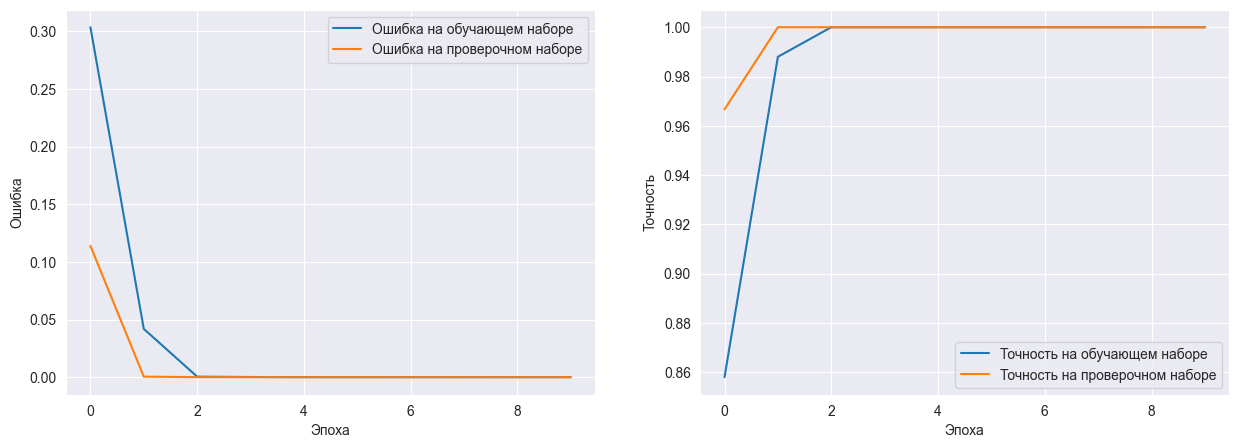

In [17]:
compile_and_learn2(model, signal_1_fft_train,  signal_2_fft_train, y_train, signal_1_fft_test, signal_2_fft_test, y_test, epochs = 10, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)